<a href="https://colab.research.google.com/github/YaokunLin/C-Instructions/blob/main/VWMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
import time
import datetime
from datetime import datetime, timedelta, date
import requests
import json

# API documentation
# https://docs.cloud.coinbase.com/exchange/reference/exchangerestapi_getproductcandles
'''
Historic rates for a product. Rates are returned in grouped buckets. 
Candle schema is of the form 
[timestamp, price_low, price_high, price_open, price_close]

max only 300 candles per requests 
'''
class VWAPCalculator(object):
  def __init__(self, pair = 'BTC-USD', endDate = None, windowSize = 200, dayDelta = 1):
    self._pair = pair
    self._apiUrl = 'https://api.pro.coinbase.com'
    self._windowSize = windowSize
    self._dayDelta = dayDelta
    endYr, endMonth, endDay = list(map(int, endDate.split('-'))) if endDate else [None, None, None]
    self._chosenDate = date(endYr, endMonth, endDay) if endDate else date.today()
    self._dateStart, self._dateEnd = self.calDates()
  
  def calDates(self):
    dateEnd = self._chosenDate
    dayDelta = timedelta(days = self._dayDelta) #intra-day when self._dayDelta = 1
    dateStart = dateEnd - (self._windowSize - 1) * dayDelta #subtract 1 to keep only 200 data points otherwise it would be 201 points
    return dateStart.isoformat(), dateEnd.isoformat()
  
  def refreshApi(self):
    parameters = {'start':self._dateStart,
                  'end':self._dateEnd,
                  'granularity': 86400}
    #The granularity field must be one of the following values: 
    #{60, 300, 900, 3600, 21600, 86400}. 
    #Otherwise, your request will be rejected. 
    #These values correspond to timeslices representing 
    #one minute, five minutes, fifteen minutes, one hour, six hours, and one day, respectively.
    response = requests.get(f"{self._apiUrl}/products/{self._pair}/candles",
                        params = parameters,
                        headers = {'content-type':'application/json'})
    
    self._response = response.json()
    '''
    Response Items
    Each bucket is an array of the following information:

    1. time bucket start time
    2. low lowest price during the bucket interval
    3. high highest price during the bucket interval
    4. open opening price (first trade) in the bucket interval
    5. close closing price (last trade) in the bucket interval
    6. volume volume of trading activity during the bucket interval
    '''

  def getVWAP(self):
    closeTimesVol=[close * vol for time, low, high, open, close, vol in self._response]
    sumVol = sum([vol for time, low, high, open, close, vol in self._response])
    if sumVol == 0: raise ZeroDivisionError("Data Not Avaliable")
    self._VWAP = sum(closeTimesVol)/sumVol
    return self._VWAP

  def __str__(self):
    dayDelta = timedelta(days = self._dayDelta)
    windwSize = len(self._response)
    return f"{self._pair}, Fr: {self._chosenDate - windwSize * dayDelta}, To: {self._chosenDate}, windwSize, {windwSize}, VWAP: ${self._VWAP}"

  def updateDate(self, endDate):
    endYr, endMonth, endDay = list(map(int, endDate.split('-')))
    self._chosenDate = date(endYr, endMonth, endDay)
    self._dateStart, self._dateEnd = self.calDates()



In [208]:
import time
print("Today's date:", date.today())

t0 = time.process_time()
btcUsdVwaps = VWAPCalculator() # dafault window is [today - 199 days, today]
btcUsdVwaps.refreshApi()
_ = btcUsdVwaps.getVWAP()
print(btcUsdVwaps)
t1 = time.process_time()
exeTime = t1 - t0
print('exe time:', exeTime)


print('----tests----')
testDates = sorted(['2021-01-01','2020-01-01','2022-01-01', '2021-11-11', '2015-10-15', '2015-07-20'])

for d in testDates:
  btcUsdVwaps.updateDate(d)
  btcUsdVwaps.refreshApi()
  _ = btcUsdVwaps.getVWAP()
  print(btcUsdVwaps)


Today's date: 2021-11-10
BTC-USD, Fr: 2021-04-24, To: 2021-11-10, windwSize, 200, VWAP: $44444.989169378736
exe time: 0.015786482999999407
----tests----
BTC-USD, Fr: 2015-07-19, To: 2015-07-20, windwSize, 1, VWAP: $280.0
BTC-USD, Fr: 2015-07-19, To: 2015-10-15, windwSize, 88, VWAP: $245.52869445853514
BTC-USD, Fr: 2019-06-15, To: 2020-01-01, windwSize, 200, VWAP: $9798.874411759945
BTC-USD, Fr: 2020-06-15, To: 2021-01-01, windwSize, 200, VWAP: $14998.043490869468
BTC-USD, Fr: 2021-04-26, To: 2021-11-11, windwSize, 199, VWAP: $44424.352391603046
BTC-USD, Fr: 2021-08-06, To: 2022-01-01, windwSize, 148, VWAP: $45393.96045656661


In [202]:
print("Today's date:", date.today())

t0 = time.process_time()
ethUsdVwaps = VWAPCalculator(pair = 'ETH-USD') # dafault window is [today - 199 days, today]
ethUsdVwaps.refreshApi()
_ = ethUsdVwaps.getVWAP()
print(ethUsdVwaps)
t1 = time.process_time()
exeTime = t1 - t0
print('exe time:', exeTime)

print('----tests----')
testDates = sorted(['2021-01-01','2020-01-01','2022-01-01', '2021-11-11', '2016-09-30', '2016-05-18'])

for d in testDates:
  ethUsdVwaps.updateDate(d)
  ethUsdVwaps.refreshApi()
  _ = ethUsdVwaps.getVWAP()
  print(ethUsdVwaps)

Today's date: 2021-11-10
ETH-USD, Fr: 2021-04-24, To: 2021-11-10, windwSize, 200, VWAP: $2961.8498815107514
exe time: 0.01475369799999271
----tests----
ETH-USD, Fr: 2016-05-17, To: 2016-05-18, windwSize, 1, VWAP: $13.18
ETH-USD, Fr: 2016-05-19, To: 2016-09-30, windwSize, 134, VWAP: $12.46493878221231
ETH-USD, Fr: 2019-06-15, To: 2020-01-01, windwSize, 200, VWAP: $211.30496150602426
ETH-USD, Fr: 2020-06-15, To: 2021-01-01, windwSize, 200, VWAP: $439.81925260179594
ETH-USD, Fr: 2021-04-26, To: 2021-11-11, windwSize, 199, VWAP: $2964.930936541681
ETH-USD, Fr: 2021-08-06, To: 2022-01-01, windwSize, 148, VWAP: $3001.2679498129773


In [201]:
print("Today's date:", date.today())

t0 = time.process_time()
ethBtcVwaps = VWAPCalculator(pair = 'ETH-BTC') # dafault window is [today - 199 days, today]
ethBtcVwaps.refreshApi()
_ = ethBtcVwaps.getVWAP()
print(ethBtcVwaps)
t1 = time.process_time()
exeTime = t1 - t0
print('exe time:', exeTime)

print('----tests----')
testDates = sorted(['2021-01-01','2020-01-01','2022-01-01', '2021-11-11', '2016-09-30', '2016-05-18'])

for d in testDates:
  ethBtcVwaps.updateDate(d)
  ethBtcVwaps.refreshApi()
  _ = ethBtcVwaps.getVWAP()
  print(ethBtcVwaps)

Today's date: 2021-11-10
ETH-BTC, Fr: 2021-04-24, To: 2021-11-10, windwSize, 200, VWAP: $0.06622987517922944
exe time: 0.017401953999993225
----tests----
ETH-BTC, Fr: 2016-05-17, To: 2016-05-18, windwSize, 1, VWAP: $0.0293
ETH-BTC, Fr: 2016-05-18, To: 2016-09-30, windwSize, 135, VWAP: $0.02033232382213174
ETH-BTC, Fr: 2019-06-15, To: 2020-01-01, windwSize, 200, VWAP: $0.02197601925178166
ETH-BTC, Fr: 2020-06-15, To: 2021-01-01, windwSize, 200, VWAP: $0.030595392942664668
ETH-BTC, Fr: 2021-04-26, To: 2021-11-11, windwSize, 199, VWAP: $0.06634663634701914
ETH-BTC, Fr: 2021-08-06, To: 2022-01-01, windwSize, 148, VWAP: $0.06652584946447807


In [248]:
import unittest

class TestVWAPCalculator(unittest.TestCase):

    def test_btcUsd1(self):
        '''Test case function for btcUsd'''
        self.calc = VWAPCalculator(windowSize = 1)
        self.calc.updateDate('2021-11-08')
        self.calc.refreshApi()
        result = self.calc.getVWAP()
        expected = 67554.84
        self.assertEqual(round(result, 5), round(expected, 5))

    def test_btcUsd2(self):
        '''Test case function for btcUsd'''
        self.calc = VWAPCalculator(windowSize = 2)
        self.calc.updateDate('2021-11-08')
        self.calc.refreshApi()
        result = self.calc.getVWAP()
        expected = (67554.84 * 17661.872972 + 63309.13 * 5596.024607) / (17661.872972 + 5596.024607)  
        self.assertEqual(round(result, 5), round(expected, 5))
  
    def test_ethUSD1(self):
        '''Test case function for ethUsd'''
        self.calc = VWAPCalculator(windowSize = 2, pair = 'ETH-USD')
        self.calc.updateDate('2021-11-08')
        self.calc.refreshApi()
        result = self.calc.getVWAP()
        expected = (4811.90 * 163884.293503 + 4617.02 * 85312.856137) / (163884.293503 + 85312.856137)  
        self.assertEqual(round(result, 5), round(expected, 5))

    def test_ethUSD2(self):
        '''Test case function for ethUsd'''
        self.calc = VWAPCalculator(windowSize = 1, pair = 'ETH-USD')
        self.calc.updateDate('2021-10-22')
        self.calc.refreshApi()
        result = self.calc.getVWAP()
        expected = 3971.55  
        self.assertEqual(round(result, 5), round(expected, 5))

    def test_ethBTC1(self):
        '''Test case function for ethUsd'''
        self.calc = VWAPCalculator(windowSize = 2, pair = 'ETH-BTC')
        self.calc.updateDate('2021-11-02')
        self.calc.refreshApi()
        result = self.calc.getVWAP()
        expected = (0.07262 * 36025.627982 + 0.07092 * 24140.364351) / (36025.627982 + 24140.364351)  
        self.assertEqual(round(result, 5), round(expected, 5))

    def test_ethBTC1(self):
        '''Test case function for ethUsd'''
        self.calc = VWAPCalculator(windowSize = 2, pair = 'ETH-BTC')
        self.calc.updateDate('2021-11-02')
        self.calc.refreshApi()
        result = self.calc.getVWAP()
        expected = (0.07262 * 36025.627982 + 0.07092 * 24140.364351) / (36025.627982 + 24140.364351)  
        self.assertEqual(round(result, 5), round(expected, 5))

    def test_ethBTC1(self):
        '''Test case function for ethUsd'''
        self.calc = VWAPCalculator(windowSize = 1, pair = 'ETH-BTC')
        self.calc.updateDate('2016-05-18')
        self.calc.refreshApi()
        result = self.calc.getVWAP()
        expected = 0.0293 
        self.assertEqual(round(result, 5), round(expected, 5))

In [249]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_btcUsd1 (__main__.TestCalculator)
Test case function for btcUsd ... ok
test_btcUsd2 (__main__.TestCalculator)
Test case function for btcUsd ... ok
test_btcUsd1 (__main__.TestVWAPCalculator)
Test case function for btcUsd ... ok
test_btcUsd2 (__main__.TestVWAPCalculator)
Test case function for btcUsd ... ok
test_ethBTC1 (__main__.TestVWAPCalculator)
Test case function for ethUsd ... ok
test_ethUSD1 (__main__.TestVWAPCalculator)
Test case function for ethUsd ... ok
test_ethUSD2 (__main__.TestVWAPCalculator)
Test case function for ethUsd ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.653s

OK


{'start': '2021-04-25', 'end': '2021-11-10', 'granularity': 86400}
[[1636502400,0.07037,0.07101,0.0707,0.07074,1314.96295434],[1636416000,0.07022,0.0718,0.07121,0.07069,10811.15997216],[1636329600,0.07093,0.07294,0.0729,0.07121,14897.52053634],[1636243200,0.0729,0.07478,0.0735,0.07293,8816.45802449],[1636156800,0.07203,0.07376,0.07342,0.07352,7202.58894783],[1636070400,0.07283,0.07387,0.07384,0.07341,9761.60679465],[1635984000,0.07262,0.07399,0.07318,0.07385,12228.15314842],[1635897600,0.07222,0.07464,0.07263,0.07319,20115.80676978],[1635811200,0.06998,0.07307,0.07094,0.07262,36025.62798176],[1635724800,0.06916,0.07132,0.06994,0.07092,24140.36435101],[1635638400,0.06912,0.07121,0.06988,0.06993,9771.76836692],[1635552000,0.06932,0.07111,0.07099,0.06987,8886.31484748],[1635465600,0.0702,0.07179,0.07077,0.07096,19174.43994384],[1635379200,0.06697,0.07136,0.06712,0.07075,23700.2526245],[1635292800,0.067,0.07033,0.06847,0.06712,22798.36450047],[1635206400,0.0668,0.06938,0.06693,0.06846,1363

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efdd62eaf50>,
      dtype=object)

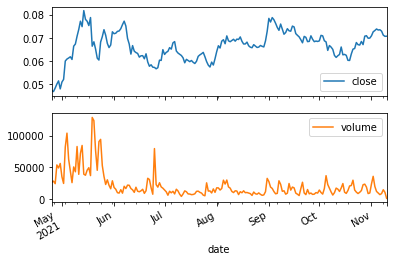

In [251]:
# Scratch work for testing purposes
# GET https://api.exchange.coinbase.com/products/{product_id}/candles

import requests
import pandas as pd
import time
from datetime import datetime, timedelta


pair = 'ETH-BTC' #'ETH-USD' #'BTC-USD'
pair2 = 'ETH-USD'
pair3 = 'ETH-BTC'
windowSize = 200 #sliding window of 200 data points / max only 300 candles per requests 
#apiUrl = "https://api.exchange.coinbase.com"
apiUrl = 'https://api.pro.coinbase.com'


# work with Timeframe
timeEnd = date.today()#datetime.now()
delta = timedelta(days = 1) #intra-day
timeStart = timeEnd - (windowSize - 1) * delta
timeStart, timeEnd = timeStart.isoformat(), timeEnd.isoformat()
#print('timeStart: ', timeStart,' timeEnd: ', timeEnd)
# work with Timeframe

parameters = {'start':timeStart,
          'end':timeEnd,
          'granularity': 86400} 
 #The granularity field must be one of the following values: 
 #{60, 300, 900, 3600, 21600, 86400}. 
 #Otherwise, your request will be rejected. 
 #These values correspond to timeslices representing 
 #one minute, five minutes, fifteen minutes, one hour, six hours, and one day, respectively.
 

print(parameters)


response = requests.get(f"{apiUrl}/products/{pair}/candles",
                        params = parameters,
                        headers = {'content-type':'application/json'})

'''
Response Items
Each bucket is an array of the following information:

time bucket start time
low lowest price during the bucket interval
high highest price during the bucket interval
open opening price (first trade) in the bucket interval
close closing price (last trade) in the bucket interval
volume volume of trading activity during the bucket interval
'''
print(response.text)
print(len(response.text))

df = pd.DataFrame(response.json(),
                  columns = ['time', 'low', 'high', 'open', 'close', 'volume'])

df['date'] = pd.to_datetime(df['time'], unit='s')
df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
df.set_index('date', inplace = True)

print(df)
print(pair)
a = sum(df['close'] * df['volume']) / sum(df['volume'])
print(windowSize,'days VWAP',a)

df[['close', 'volume']].plot.line(subplots=True)